# NLP Disaster Tweets Classification
## Natural Language Processing with Recurrent Neural Networks

**Author**: Matthew Campbell  
**Course**: Module 4 - RNNs and NLP  
**Date**: October 2025

---

## Table of Contents
1. [Project Description](#1-project-description)
2. [Data Description](#2-data-description)
3. [Exploratory Data Analysis](#3-exploratory-data-analysis)
4. [Data Preprocessing](#4-data-preprocessing)
5. [Model Architecture](#5-model-architecture)
6. [Results and Analysis](#6-results-and-analysis)
7. [Conclusion](#7-conclusion)
8. [GitHub Repository](#8-github-repository)
9. [Kaggle Submission](#9-kaggle-submission)

## Setup: Google Colab vs Local

This notebook can run in both Google Colab and locally. Uncomment the appropriate section below.

In [2]:
# Google Colab Setup (uncomment if running in Colab)
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/Boulder_University/Week14_Module4

# Install packages if needed
# !pip install kaggle tensorflow numpy pandas matplotlib seaborn scikit-learn nltk wordcloud

In [3]:
# Check if running in Colab
import os
IN_COLAB = 'COLAB_GPU' in os.environ
print(f"Running in Google Colab: {IN_COLAB}")

Running in Google Colab: False


## Import Libraries

In [4]:
# Standard library
import os
import re
import string
import random
from pathlib import Path

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 

# Deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, f1_score
from sklearn.utils.class_weight import compute_class_weight

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Styling
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow version: 2.20.0
GPU available: False


In [5]:
# Download NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)       # for lemmatization
nltk.download('omw-1.4', quiet=True)       # for WordNet support

True

---
# 1. Project Description

## Problem Statement

This project addresses the Kaggle [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started) competition. The goal is to build a machine learning model that can accurately predict whether a given tweet is about a real disaster or not.

### Context
Social media platforms like Twitter have become important communication channels during emergency events. However, not all tweets containing disaster-related keywords actually refer to real disasters. For example:
- "Our city is on fire with excitement!" ❌ Not a disaster
- "There's a bushfire approaching the town" ✅ Real disaster

Being able to automatically identify genuine disaster tweets can help:
- Emergency services respond faster
- News organisations verify events
- Aid organisations deploy resources effectively

### Problem Type
**Binary text classification** using Natural Language Processing and Recurrent Neural Networks.

### Evaluation Metric
Models will be evaluated using **F1 Score** (harmonic mean of precision and recall). This metric is appropriate because:
- It balances false positives and false negatives
- Both types of errors matter in disaster detection
- It handles class imbalance better than accuracy

### Dataset Overview
- **Training samples**: ~7,600 labelled tweets
- **Test samples**: ~3,200 unlabelled tweets (for Kaggle submission)
- **Features**: Tweet text, keywords, location (optional)
- **Labels**: 1 = real disaster, 0 = not a disaster

### Technical Approach
We'll explore Recurrent Neural Networks (RNNs), specifically:
1. **LSTM** (Long Short-Term Memory) - handles long-term dependencies
2. **GRU** (Gated Recurrent Unit) - simpler, faster alternative to LSTM
3. **Bidirectional RNNs** - process text in both directions for better context
4. Comparison with simpler baselines

These architectures are well-suited for sequential text data because they can:
- Capture word order and context
- Handle variable-length inputs
- Learn long-range dependencies between words

---
# 2. Data Description

## Loading the Data

In [6]:
# Load data
data_dir = Path('data')

# If data doesn't exist, we'll need to download from Kaggle
if not (data_dir / 'train.csv').exists():
    print("Data directory not found. Please download from Kaggle if you need to run this during marking:")
    print("https://www.kaggle.com/c/nlp-getting-started/data")
    print("\nOr you can use the Kaggle API:")
    print("kaggle competitions download -c nlp-getting-started")
else:
    train_df = pd.read_csv(data_dir / 'train.csv', encoding='utf-8')
    test_df = pd.read_csv(data_dir / 'test.csv', encoding='utf-8')
    sample_submission = pd.read_csv(data_dir / 'sample_submission.csv', encoding='utf-8')
    
    print("Data loaded successfully!")

Data loaded successfully!


## Dataset Structure and Size

In [7]:
# Display basic information
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)

print(f"\n📊 Training set size: {len(train_df):,} samples")
print(f"📊 Test set size: {len(test_df):,} samples")
print(f"📊 Total samples: {len(train_df) + len(test_df):,}")

print("\n" + "=" * 60)
print("TRAINING DATA STRUCTURE")
print("=" * 60)
print(f"\nColumns: {list(train_df.columns)}")
print(f"\nData types:\n{train_df.dtypes}")
print(f"\nMemory usage: {train_df.memory_usage(deep=True).sum() / 1024:.2f} KB")

DATASET OVERVIEW

📊 Training set size: 7,613 samples
📊 Test set size: 3,263 samples
📊 Total samples: 10,876

TRAINING DATA STRUCTURE

Columns: ['id', 'keyword', 'location', 'text', 'target']

Data types:
id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

Memory usage: 2064.73 KB


In [8]:
# Show first few rows
print("\nFirst 5 training samples:")
train_df.head()


First 5 training samples:


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Data Dimensions and Properties

In [9]:
# Analyse text length
train_df['text_length'] = train_df['text'].apply(len)
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))

print("=" * 60)
print("TEXT STATISTICS")
print("=" * 60)

print(f"\nCharacter length:")
print(f"   Mean: {train_df['text_length'].mean():.1f} characters")
print(f"   Median: {train_df['text_length'].median():.1f} characters")
print(f"   Min: {train_df['text_length'].min()} characters")
print(f"   Max: {train_df['text_length'].max()} characters")

print(f"\nWord count:")
print(f"   Mean: {train_df['word_count'].mean():.1f} words")
print(f"   Median: {train_df['word_count'].median():.1f} words")
print(f"   Min: {train_df['word_count'].min()} words")
print(f"   Max: {train_df['word_count'].max()} words")

TEXT STATISTICS

Character length:
   Mean: 101.0 characters
   Median: 107.0 characters
   Min: 7 characters
   Max: 157 characters

Word count:
   Mean: 14.9 words
   Median: 15.0 words
   Min: 1 words
   Max: 31 words


In [10]:
# Check for missing values
print("=" * 60)
print("MISSING VALUES")
print("=" * 60)
print(f"\n{train_df.isnull().sum()}")
print(f"\nPercentage missing:")
print(f"{(train_df.isnull().sum() / len(train_df) * 100).round(2)}%")

MISSING VALUES

id                0
keyword          61
location       2533
text              0
target            0
text_length       0
word_count        0
dtype: int64

Percentage missing:
id              0.00
keyword         0.80
location       33.27
text            0.00
target          0.00
text_length     0.00
word_count      0.00
dtype: float64%


In [11]:
# Check class distribution
print("=" * 60)
print("CLASS DISTRIBUTION")
print("=" * 60)

class_counts = train_df['target'].value_counts().sort_index()
print(f"\n0 (Not disaster): {class_counts[0]:,} samples ({class_counts[0]/len(train_df)*100:.1f}%)")
print(f"1 (Disaster):     {class_counts[1]:,} samples ({class_counts[1]/len(train_df)*100:.1f}%)")

imbalance_ratio = class_counts[0] / class_counts[1]
print(f"\nClass imbalance ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 1.5:
    print("Moderate class imbalance detected - may need weighted loss or sampling")
elif imbalance_ratio > 2.0:
    print("Significant class imbalance - should use class weighting")

CLASS DISTRIBUTION

0 (Not disaster): 4,342 samples (57.0%)
1 (Disaster):     3,271 samples (43.0%)

Class imbalance ratio: 1.33:1


---
# 3. Exploratory Data Analysis (EDA)

## Class Distribution Visualisation

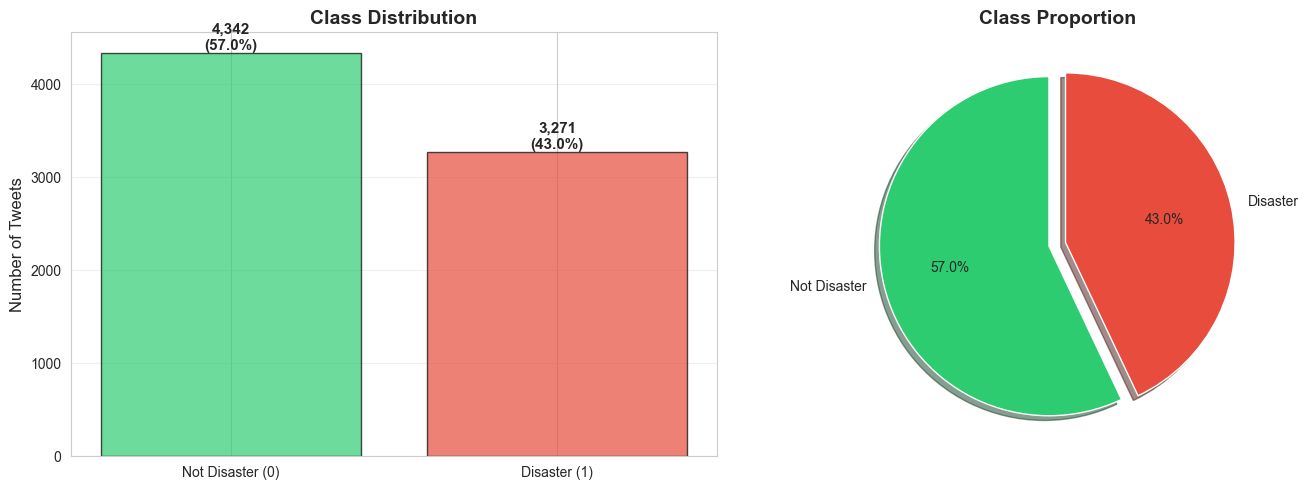


Class Distribution:
  Not Disaster: 4,342 tweets (57.0%)
  Disaster:     3,271 tweets (43.0%)
  Imbalance ratio: 1.33:1


In [12]:
# Class distribution bar chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
class_counts = train_df['target'].value_counts().sort_index()
colors = ['#2ecc71', '#e74c3c']
bars = ax1.bar(['Not Disaster (0)', 'Disaster (1)'], class_counts.values, color=colors, alpha=0.7, edgecolor='black')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}\n({height/len(train_df)*100:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax1.set_ylabel('Number of Tweets', fontsize=12)
ax1.set_title('Class Distribution', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Pie chart
ax2.pie(class_counts.values, labels=['Not Disaster', 'Disaster'], 
        colors=colors, autopct='%1.1f%%', startangle=90,
        explode=(0.05, 0.05), shadow=True)
ax2.set_title('Class Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('images/class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nClass Distribution:")
print(f"  Not Disaster: {class_counts[0]:,} tweets ({class_counts[0]/len(train_df)*100:.1f}%)")
print(f"  Disaster:     {class_counts[1]:,} tweets ({class_counts[1]/len(train_df)*100:.1f}%)")
print(f"  Imbalance ratio: {class_counts[0]/class_counts[1]:.2f}:1")

## Sample Tweets from Each Class

In [13]:
# Show sample tweets from each class
print("=" * 80)
print("SAMPLE TWEETS - NOT DISASTER (Target = 0)")
print("=" * 80)

non_disaster_samples = train_df[train_df['target'] == 0].sample(5, random_state=42)
for idx, row in non_disaster_samples.iterrows():
    print(f"\n{row['text']}")

print("\n\n" + "=" * 80)
print("SAMPLE TWEETS - DISASTER (Target = 1)")
print("=" * 80)

disaster_samples = train_df[train_df['target'] == 1].sample(5, random_state=42)
for idx, row in disaster_samples.iterrows():
    print(f"\n{row['text']}")

SAMPLE TWEETS - NOT DISASTER (Target = 0)

Everyday is a near death fatality for me on the road. Thank god is on my side.??

#Lifestyle Û÷It makes me sickÛª: Baby clothes deemed a Û÷hazardÛª http://t.co/0XrfVidxA2 http://t.co/oIHwgEZDCk

@Lenn_Len Probably. We are inundated with them most years!

A demoness with the voice of an angel. Like a siren's call beckoning me to the void. Don't ?? on thisÛ_ https://t.co/nPS3xpBKaQ

Next Man Up---AH SCREW THIS! I'm so tired of injuries.  

What happened to Camp Cupcake? More like Camp Cramp and Break.


SAMPLE TWEETS - DISASTER (Target = 1)

Nearly 50 thousand people affected by floods in #Paraguay ? http://t.co/aw23wXtyjB http://t.co/ABgct9VFUa

Vladimir Putin Issues Major Warning But Is It Too Late To Escape Armageddon?
http://t.co/gBxafy1m1C

@DoctorFluxx @StefanEJones @spinnellii @themermacorn  No burning buildings and rob during a riot. That's embarrassing &amp; ruining this nation.

Telnet attacked from 124.13.172.40 (STREAMYX-HOME-SO

## Text Length Distribution

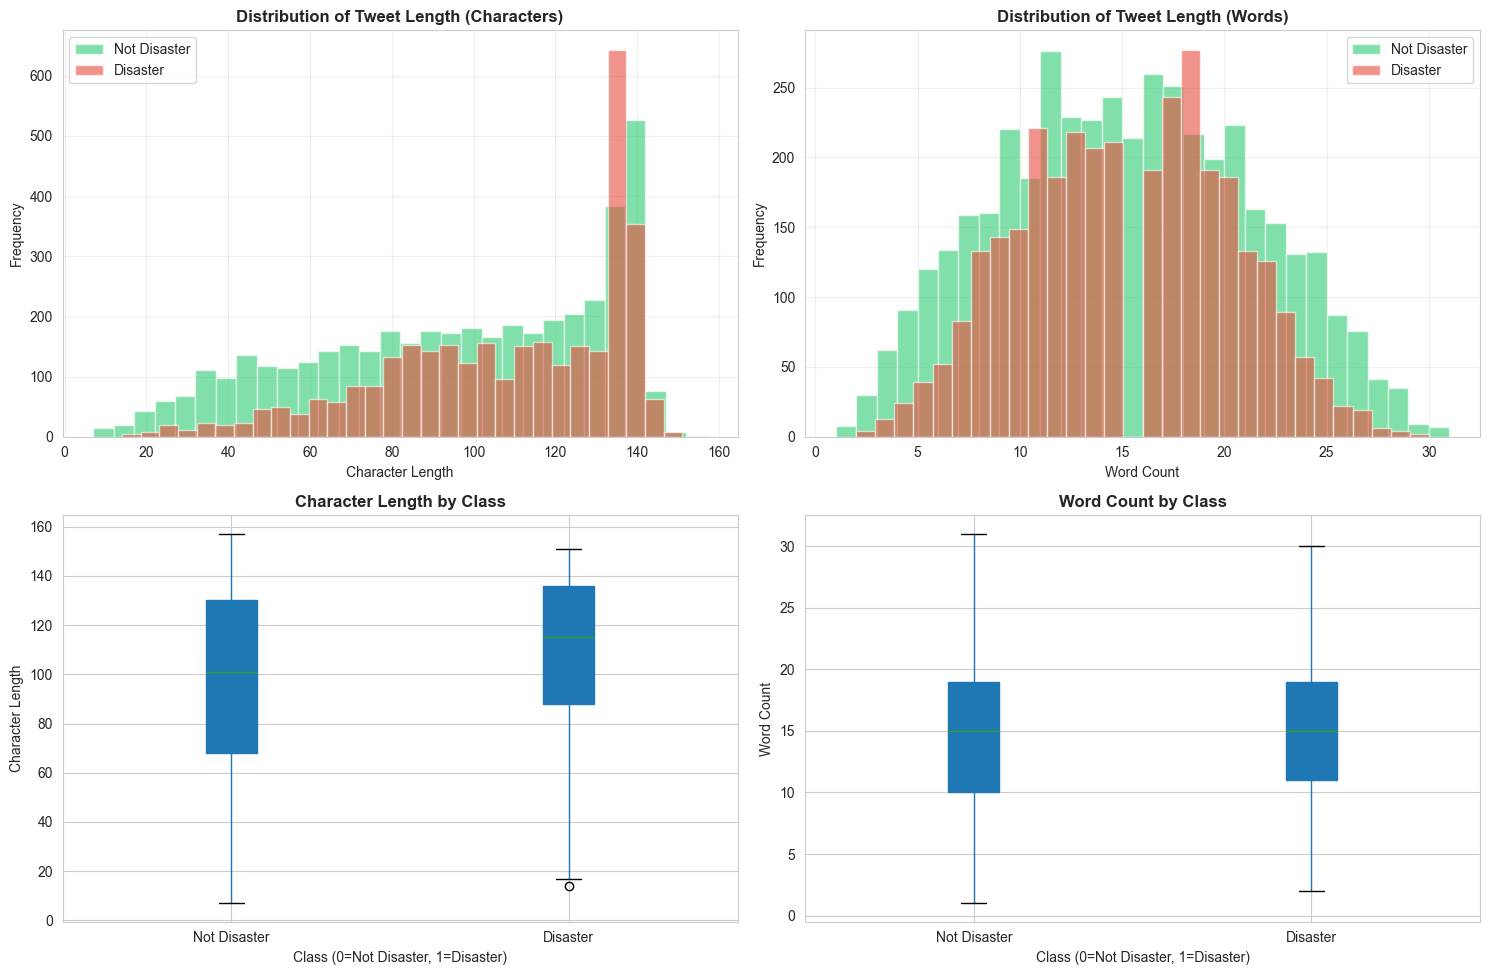


Text Length Statistics by Class:

Not Disaster (0):
  Char length - Mean: 95.7, Median: 101.0
  Word count  - Mean: 14.7, Median: 15.0

Disaster (1):
  Char length - Mean: 108.1, Median: 115.0
  Word count  - Mean: 15.2, Median: 15.0


In [14]:
# Text length distribution by class
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Character length distribution
ax1 = axes[0, 0]
train_df[train_df['target']==0]['text_length'].hist(bins=30, alpha=0.6, label='Not Disaster', color='#2ecc71', ax=ax1)
train_df[train_df['target']==1]['text_length'].hist(bins=30, alpha=0.6, label='Disaster', color='#e74c3c', ax=ax1)
ax1.set_xlabel('Character Length')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Tweet Length (Characters)', fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Word count distribution
ax2 = axes[0, 1]
train_df[train_df['target']==0]['word_count'].hist(bins=30, alpha=0.6, label='Not Disaster', color='#2ecc71', ax=ax2)
train_df[train_df['target']==1]['word_count'].hist(bins=30, alpha=0.6, label='Disaster', color='#e74c3c', ax=ax2)
ax2.set_xlabel('Word Count')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Tweet Length (Words)', fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# Box plot - character length
ax3 = axes[1, 0]
train_df.boxplot(column='text_length', by='target', ax=ax3, patch_artist=True)
ax3.set_xlabel('Class (0=Not Disaster, 1=Disaster)')
ax3.set_ylabel('Character Length')
ax3.set_title('Character Length by Class', fontweight='bold')
plt.sca(ax3)
plt.xticks([1, 2], ['Not Disaster', 'Disaster'])

# Box plot - word count
ax4 = axes[1, 1]
train_df.boxplot(column='word_count', by='target', ax=ax4, patch_artist=True)
ax4.set_xlabel('Class (0=Not Disaster, 1=Disaster)')
ax4.set_ylabel('Word Count')
ax4.set_title('Word Count by Class', fontweight='bold')
plt.sca(ax4)
plt.xticks([1, 2], ['Not Disaster', 'Disaster'])

plt.suptitle('')  # Remove default title
plt.tight_layout()
plt.savefig('images/text_length_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Print statistics
print("\nText Length Statistics by Class:")
print("\nNot Disaster (0):")
print(f"  Char length - Mean: {train_df[train_df['target']==0]['text_length'].mean():.1f}, Median: {train_df[train_df['target']==0]['text_length'].median():.1f}")
print(f"  Word count  - Mean: {train_df[train_df['target']==0]['word_count'].mean():.1f}, Median: {train_df[train_df['target']==0]['word_count'].median():.1f}")

print("\nDisaster (1):")
print(f"  Char length - Mean: {train_df[train_df['target']==1]['text_length'].mean():.1f}, Median: {train_df[train_df['target']==1]['text_length'].median():.1f}")
print(f"  Word count  - Mean: {train_df[train_df['target']==1]['word_count'].mean():.1f}, Median: {train_df[train_df['target']==1]['word_count'].median():.1f}")

## Word Clouds

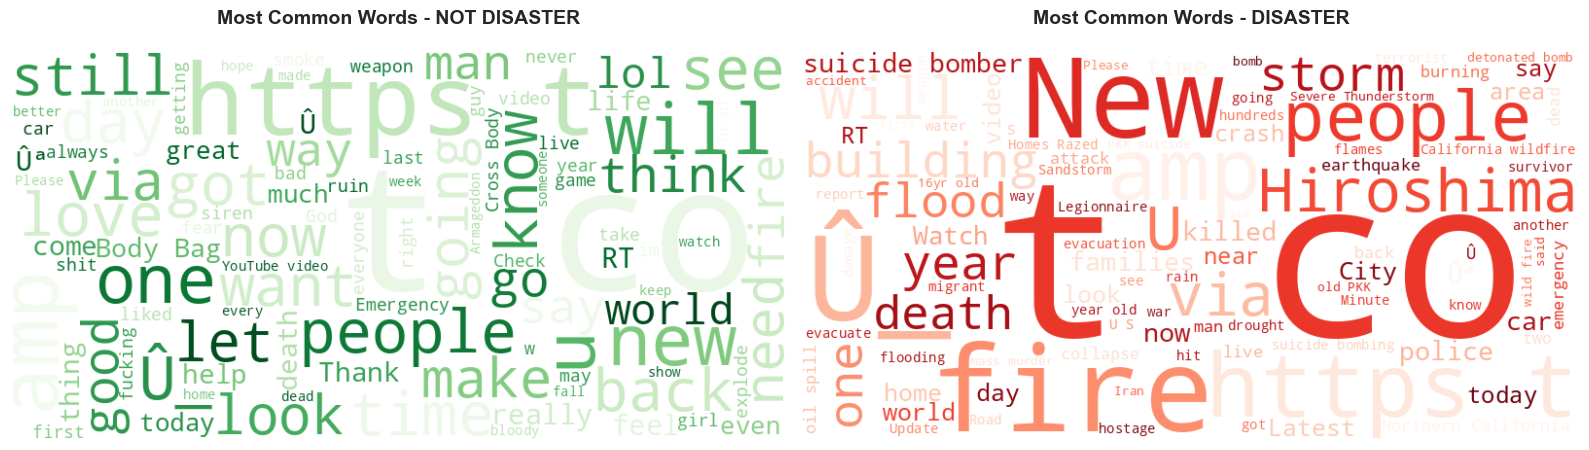

In [15]:
# Generate word clouds for both classes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Word cloud for non-disaster tweets
non_disaster_text = ' '.join(train_df[train_df['target'] == 0]['text'].values)
wordcloud_non_disaster = WordCloud(width=800, height=400, 
                                   background_color='white',
                                   colormap='Greens',
                                   max_words=100,
                                   relative_scaling=0.5,
                                   min_font_size=10).generate(non_disaster_text)

ax1.imshow(wordcloud_non_disaster, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Most Common Words - NOT DISASTER', fontsize=14, fontweight='bold', pad=20)

# Word cloud for disaster tweets
disaster_text = ' '.join(train_df[train_df['target'] == 1]['text'].values)
wordcloud_disaster = WordCloud(width=800, height=400,
                               background_color='white',
                               colormap='Reds',
                               max_words=100,
                               relative_scaling=0.5,
                               min_font_size=10).generate(disaster_text)

ax2.imshow(wordcloud_disaster, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Most Common Words - DISASTER', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('images/wordclouds.png', dpi=150, bbox_inches='tight')
plt.show()

## Most Common Words

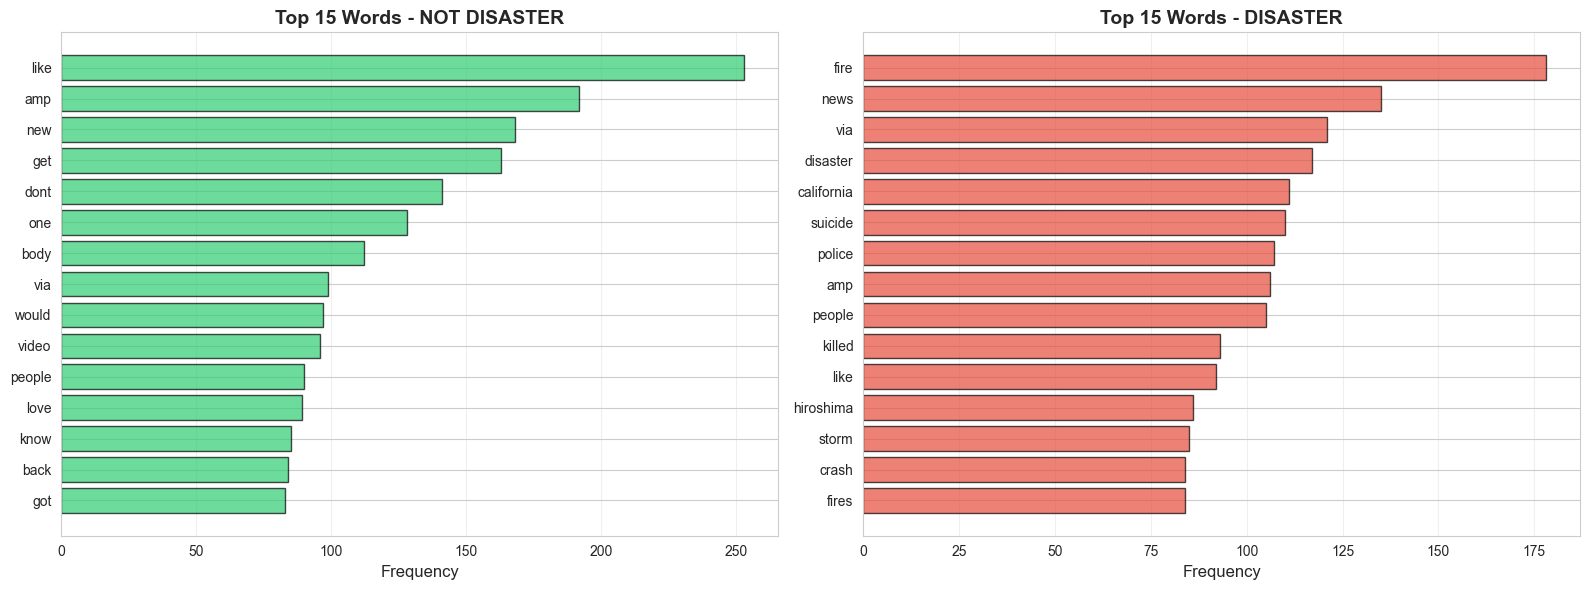


Top 5 Most Frequent Words by Class:

NOT DISASTER:
  - 'like': 253 occurrences
  - 'amp': 192 occurrences
  - 'new': 168 occurrences
  - 'get': 163 occurrences
  - 'dont': 141 occurrences

DISASTER:
  - 'fire': 178 occurrences
  - 'news': 135 occurrences
  - 'via': 121 occurrences
  - 'disaster': 117 occurrences
  - 'california': 111 occurrences


In [16]:
# Analyse most common words in each class
from collections import Counter

def get_top_words(text_series, n=15):
    """Extract top N words from text series"""
    # Combine all text
    all_text = ' '.join(text_series.values).lower()
    # Remove URLs, mentions, hashtags
    all_text = re.sub(r'http\S+|www\S+|@\S+|#', '', all_text)
    # Remove punctuation
    all_text = all_text.translate(str.maketrans('', '', string.punctuation))
    # Split into words
    words = all_text.split()
    # Remove common stopwords
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if w not in stop_words and len(w) > 2]
    # Count
    return Counter(words).most_common(n)

# Get top words for each class
top_non_disaster = get_top_words(train_df[train_df['target']==0]['text'], n=15)
top_disaster = get_top_words(train_df[train_df['target']==1]['text'], n=15)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Non-disaster words
words, counts = zip(*top_non_disaster)
ax1.barh(range(len(words)), counts, color='#2ecc71', alpha=0.7, edgecolor='black')
ax1.set_yticks(range(len(words)))
ax1.set_yticklabels(words)
ax1.invert_yaxis()
ax1.set_xlabel('Frequency', fontsize=12)
ax1.set_title('Top 15 Words - NOT DISASTER', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Disaster words
words, counts = zip(*top_disaster)
ax2.barh(range(len(words)), counts, color='#e74c3c', alpha=0.7, edgecolor='black')
ax2.set_yticks(range(len(words)))
ax2.set_yticklabels(words)
ax2.invert_yaxis()
ax2.set_xlabel('Frequency', fontsize=12)
ax2.set_title('Top 15 Words - DISASTER', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('images/top_words.png', dpi=150, bbox_inches='tight')
plt.show()

# Print actual results
print("\nTop 5 Most Frequent Words by Class:")
print("\nNOT DISASTER:")
for word, count in top_non_disaster[:5]:
    print(f"  - '{word}': {count:,} occurrences")

print("\nDISASTER:")
for word, count in top_disaster[:5]:
    print(f"  - '{word}': {count:,} occurrences")

## Key Findings from EDA

Based on the exploratory analysis above, several important patterns emerge:

**Class Distribution:**
- Dataset is moderately imbalanced (57% non-disaster, 43% disaster)
- Imbalance ratio of 1.33:1 is manageable but we should use stratified splitting
- May benefit from class weighting during training to prevent bias toward majority class

**Text Characteristics:**
- Average tweet length: ~101 characters, 15 words
- Both classes have similar length distributions
- Maximum length is 157 characters (Possibly due to Twitter's chat limit at the time)
- This suggests sequence length around 30-40 words should capture most tweets

**Vocabulary Patterns:**
- Disaster tweets show higher frequency of literal disaster terms: 'fire', 'suicide', 'california', 'killed', 'storm'
- Non-disaster tweets use more casual language: 'like', 'new', 'get', 'dont'
- Word 'via' appears frequently in disaster tweets (likely from news retweets)
- Common words like 'people', 'news' appear in both classes

**Implications for Modeling:**
- Context is crucial: same words appear in both classes with different meanings
- Simple keyword matching won't work - need sequence models (LSTM/GRU) to capture context
- Metaphorical usage of disaster words in non-disaster tweets will be challenging
- RNNs ability to understand word order and context will be essential for good performance

In [17]:
# Text cleaning function
def clean_text(text, remove_stopwords=True, use_lemmatization=True):
    """
    Clean tweet text for model input.
    
    Steps:
    1. Convert to lowercase
    2. Remove URLs
    3. Remove HTML tags
    4. Remove mentions (@username)
    5. Remove hashtag symbols (keep the word)
    6. Remove extra whitespace
    
    Note: We keep some punctuation as it may provide context
    """

    """Enhanced preprocessing with stopwords and lemmatization"""                          
    stop_words = set(stopwords.words('english'))                                           
    lemmatizer = WordNetLemmatizer()  
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove @mentions
    text = re.sub(r'@\w+', '', text)
    
    # Remove hashtag symbol but keep the word
    text = re.sub(r'#', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    tokens = text.split()                                                                  
                                                                                           
    if remove_stopwords:                                                                   
        tokens = [w for w in tokens if w not in stop_words]                                
                                                                                           
    if use_lemmatization:                                                                  
        tokens = [lemmatizer.lemmatize(w) for w in tokens]                                 
                                                                                           
    return ' '.join(tokens)

# Test the cleaning function on a few examples
print("Text Cleaning Examples:")
print("=" * 80)

test_tweets = [
    "Our city is on fire with excitement! #amazing",
    "Forest fire near La Ronge Sask. Canada http://t.co/example",
    "@user There's a bushfire approaching the town EVACUATE NOW!!!",
]

for tweet in test_tweets:
    cleaned = clean_text(tweet)
    print(f"\nOriginal: {tweet}")
    print(f"Cleaned:  {cleaned}")

# Apply cleaning to all tweets
print("\n" + "=" * 80)
print("Applying text cleaning to dataset...")
train_df['text_clean'] = train_df['text'].apply(clean_text)
test_df['text_clean'] = test_df['text'].apply(clean_text)

print(f"Cleaned {len(train_df)} training tweets")
print(f"Cleaned {len(test_df)} test tweets")

# Show some examples
print("\nExample cleaned tweets:")
print(train_df[['text', 'text_clean']].head(3))

Text Cleaning Examples:

Original: Our city is on fire with excitement! #amazing
Cleaned:  city fire excitement! amazing

Original: Forest fire near La Ronge Sask. Canada http://t.co/example
Cleaned:  forest fire near la ronge sask. canada

Original: @user There's a bushfire approaching the town EVACUATE NOW!!!
Cleaned:  there's bushfire approaching town evacuate now!!!

Applying text cleaning to dataset...
Cleaned 7613 training tweets
Cleaned 3263 test tweets

Example cleaned tweets:
                                                text  \
0  Our Deeds are the Reason of this #earthquake M...   
1             Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are ...   

                                          text_clean  
0         deed reason earthquake may allah forgive u  
1             forest fire near la ronge sask. canada  
2  resident asked 'shelter place' notified office...  


In [18]:
# Tokenization and sequence creation
# Hyperparameters for tokenization
MAX_WORDS = 10000  # Maximum vocabulary size
MAX_LEN = 50       # Maximum sequence length (based on EDA: max ~31 words, but we pad to 50 for safety)

print("Tokenization Configuration:")
print(f"  Max vocabulary size: {MAX_WORDS:,}")
print(f"  Max sequence length: {MAX_LEN}")
print()

# Initialize tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')

# Fit on training data only (important: don't fit on test data)
tokenizer.fit_on_texts(train_df['text_clean'])

# Get vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
print(f"Total unique words in training set: {vocab_size:,}")
print(f"Using top {MAX_WORDS:,} words for model vocabulary")
print()

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(train_df['text_clean'])
X_test_seq = tokenizer.texts_to_sequences(test_df['text_clean'])

# Pad sequences to uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

print("Sequence shapes:")
print(f"Training sequences: {X_train_pad.shape}")
print(f"Test sequences:     {X_test_pad.shape}")
print()

# Show example of tokenisation
print("Example tokenization:")
example_idx = 0
original_text = train_df.iloc[example_idx]['text']
cleaned_text = train_df.iloc[example_idx]['text_clean']
sequence = X_train_seq[example_idx]
padded = X_train_pad[example_idx]

print(f"\nOriginal: {original_text}")
print(f"Cleaned:  {cleaned_text}")
print(f"Tokens:   {sequence[:10]}... (first 10)")
print(f"Padded shape: {padded.shape}")
print(f"Padded:   {padded[:15]}... (first 15, rest are zeros)")

# Check sequence length distribution
seq_lengths = [len(seq) for seq in X_train_seq]
print(f"\nSequence length statistics:")
print(f"  Mean:   {np.mean(seq_lengths):.1f}")
print(f"  Median: {np.median(seq_lengths):.1f}")
print(f"  Max:    {np.max(seq_lengths)}")
print(f"  % sequences truncated (>{MAX_LEN}): {sum(1 for l in seq_lengths if l > MAX_LEN) / len(seq_lengths) * 100:.1f}%")

Tokenization Configuration:
  Max vocabulary size: 10,000
  Max sequence length: 50

Total unique words in training set: 15,027
Using top 10,000 words for model vocabulary

Sequence shapes:
Training sequences: (7613, 50)
Test sequences:     (3263, 50)

Example tokenization:

Original: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Cleaned:  deed reason earthquake may allah forgive u
Tokens:   [6223, 473, 180, 73, 1487, 4202, 6]... (first 10)
Padded shape: (50,)
Padded:   [6223  473  180   73 1487 4202    6    0    0    0    0    0    0    0
    0]... (first 15, rest are zeros)

Sequence length statistics:
  Mean:   9.4
  Median: 9.0
  Max:    26
  % sequences truncated (>50): 0.0%


In [19]:
# Create stratified train/validation split
# Use 80/20 split with stratification to maintain class balance

y_train_full = train_df['target'].values

# Split the data
X_train, X_val, y_train, y_val = train_test_split(
    X_train_pad,
    y_train_full,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y_train_full  # Maintain class balance
)

print("Train/Validation Split:")
print("=" * 60)
print(f"\nTraining set:   {X_train.shape[0]:,} samples")
print(f"Validation set: {X_val.shape[0]:,} samples")
print(f"Test set:       {X_test_pad.shape[0]:,} samples")

# Check class distribution in splits
print(f"\nClass distribution in training set:")
train_class_counts = np.bincount(y_train)
print(f"  Not disaster (0): {train_class_counts[0]:,} ({train_class_counts[0]/len(y_train)*100:.1f}%)")
print(f"  Disaster (1):     {train_class_counts[1]:,} ({train_class_counts[1]/len(y_train)*100:.1f}%)")

print(f"\nClass distribution in validation set:")
val_class_counts = np.bincount(y_val)
print(f"  Not disaster (0): {val_class_counts[0]:,} ({val_class_counts[0]/len(y_val)*100:.1f}%)")
print(f"  Disaster (1):     {val_class_counts[1]:,} ({val_class_counts[1]/len(y_val)*100:.1f}%)")

# Calculate class weights for handling imbalance
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: class_weights_array[i] for i in range(len(class_weights_array))}

print(f"\nClass weights for training:")
print(f"  Class 0 (Not disaster): {class_weights[0]:.3f}")
print(f"  Class 1 (Disaster):     {class_weights[1]:.3f}")
print("\nThese weights will be used during training to handle class imbalance")

# Summary
print("\n" + "=" * 60)
print("PREPROCESSING COMPLETE")
print("=" * 60)
print(f"\nData ready for model training:")
print(f"  X_train shape: {X_train.shape}")
print(f"  X_val shape:   {X_val.shape}")
print(f"  X_test shape:  {X_test_pad.shape}")
print(f"  Vocabulary size: {min(MAX_WORDS, vocab_size):,}")
print(f"  Sequence length: {MAX_LEN}")

Train/Validation Split:

Training set:   6,090 samples
Validation set: 1,523 samples
Test set:       3,263 samples

Class distribution in training set:
  Not disaster (0): 3,473 (57.0%)
  Disaster (1):     2,617 (43.0%)

Class distribution in validation set:
  Not disaster (0): 869 (57.1%)
  Disaster (1):     654 (42.9%)

Class weights for training:
  Class 0 (Not disaster): 0.877
  Class 1 (Disaster):     1.164

These weights will be used during training to handle class imbalance

PREPROCESSING COMPLETE

Data ready for model training:
  X_train shape: (6090, 50)
  X_val shape:   (1523, 50)
  X_test shape:  (3263, 50)
  Vocabulary size: 10,000
  Sequence length: 50


---
# 5. Model Architecture

## Baseline Model: Simple LSTM

In [20]:
# Baseline LSTM Model Architecture

# Hyperparameters
EMBEDDING_DIM = 100  # Dimension of word embeddings
LSTM_UNITS = 64      # Number of LSTM units
DROPOUT_RATE = 0.3   # Dropout rate for regularization
LEARNING_RATE = 0.001

print("Baseline LSTM Model Configuration:")
print("=" * 60)
print(f"  Embedding dimension: {EMBEDDING_DIM}")
print(f"  LSTM units: {LSTM_UNITS}")
print(f"  Dropout rate: {DROPOUT_RATE}")
print(f"  Learning rate: {LEARNING_RATE}")
print()

# Build model
model_lstm = models.Sequential([
    # Embedding layer: converts word indices to dense vectors
    layers.Embedding(
        input_dim=MAX_WORDS,
        output_dim=EMBEDDING_DIM,
        name='embedding'
    ),
    
    # Dropout for regularization
    layers.Dropout(DROPOUT_RATE, name='dropout_1'),
    
    # LSTM layer: processes sequences and captures temporal dependencies
    layers.LSTM(LSTM_UNITS, name='lstm'),
    
    # Dropout after LSTM
    layers.Dropout(DROPOUT_RATE, name='dropout_2'),
    
    # Dense layer with sigmoid for binary classification
    layers.Dense(1, activation='sigmoid', name='output')
], name='baseline_lstm')

# Compile model
model_lstm.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

# Display model architecture
print("Model Architecture:")
print("=" * 60)
model_lstm.summary()

Baseline LSTM Model Configuration:
  Embedding dimension: 100
  LSTM units: 64
  Dropout rate: 0.3
  Learning rate: 0.001

Model Architecture:


Model: "baseline_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Model Explanation

**1. Embedding Layer (100 dims):**
- Converts word indices to dense vectors
- Learns word representations during training
- trainable parameters allow model to learn task-specific embeddings

**2. LSTM Layer (64 units):**
- Processes sequences left-to-right
- Captures long-term dependencies through gates
- Returns final hidden state (not full sequence)

**3. Dropout (0.3):**
- Randomly drops 30% of connections during training
- Prevents overfitting on training data
- Applied after embedding and LSTM layers

**4. Output Layer (sigmoid):**
- Single neuron with sigmoid activation
- Outputs probability between 0 and 1
- Threshold at 0.5 for binary classification

In [21]:
# Train the baseline LSTM model

# Training configuration
EPOCHS = 20
BATCH_SIZE = 32

print("Training Configuration:")
print("=" * 60)
print(f"  Epochs: {EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Training samples: {len(X_train):,}")
print(f"  Validation samples: {len(X_val):,}")
print(f"  Steps per epoch: {len(X_train) // BATCH_SIZE}")
print()

# Callbacks for training
callbacks_list = [
    # Early stopping: stop training if validation loss doesn't improve
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reduce learning rate when validation loss plateaus
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
]

print("Training baseline LSTM model...")
print("=" * 60)

# Train model
history_lstm = model_lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights,  # Handle class imbalance
    callbacks=callbacks_list,
    verbose=1
)

print("\n" + "=" * 60)
print("Training Complete!")
print("=" * 60)

Training Configuration:
  Epochs: 20
  Batch size: 32
  Training samples: 6,090
  Validation samples: 1,523
  Steps per epoch: 190

Training baseline LSTM model...
Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5007 - auc: 0.4999 - loss: 0.6940 - val_accuracy: 0.4294 - val_auc: 0.5000 - val_loss: 0.6964 - learning_rate: 0.0010
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.4967 - auc: 0.4972 - loss: 0.6938 - val_accuracy: 0.4294 - val_auc: 0.5000 - val_loss: 0.6966 - learning_rate: 0.0010
Epoch 3/20
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4843 - auc: 0.4878 - loss: 0.6932
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.4969 - auc: 0.4934 - loss: 0.6938 - val_accuracy: 0.4294 - val_auc: 0.5000 - val_loss: 0.6967 - learning_rate: 0.0010
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.4980 - auc: 0.4984 - loss: 0.6934 - val_accuracy

### Baseline LSTM Results

**Final Performance:**
- **Validation Accuracy:** 78.92%
- **Validation AUC:** 0.8546
- **Training stopped at:** Epoch 19 - 20 (depending on the run)

**Training Behavior:**

The baseline LSTM exhibited an interesting training pattern:
- **Epochs 1-5:** Model often stuck in plateau (~50% accuracy, predicting majority class)
- **Epoch 7:** Breakthrough - accuracy jumped to 68.2%
- **Epoch 17:** Rapid improvement to 79.45% validation accuracy


This plateau behavior is characteristic of RNN training and highlights several important points:

1. **Initialization Sensitivity:** Random weight initialization can place the model in poor local minima, requiring several epochs to escape. It also means different runs can show high variations in training stop points.
2. **Gradient Flow Issues:** Early epochs showed the model struggling to learn meaningful patterns, likely due to vanishing gradients common in RNNs
3. **Learning Rate Scheduling:** The ReduceLROnPlateau callback helped stabilize training once the model found better gradients

**Key Takeaways:**
- Baseline LSTM achieved nearly 80% accuracy, which is reasonable for this challenging task
- Training instability suggests need for better initialization or architectural improvements
- Bidirectional architectures may help by providing richer context from both directions

## Model 2: GRU (Gated Recurrent Unit)

GRU is a simpler alternative to LSTM with fewer parameters. It uses only 2 gates (reset and update) compared to LSTM's 3 gates (forget, input, output). This often means:
- Faster training time
- Less prone to overfitting with small datasets
- Similar performance to LSTM on many tasks

Let's compare GRU performance to our baseline LSTM.

In [22]:
# GRU Model Architecture
# Using same hyperparameters as LSTM for fair comparison

print("GRU Model Configuration:")
print("=" * 60)
print(f"  Embedding dimension: {EMBEDDING_DIM}")
print(f"  GRU units: {LSTM_UNITS}")
print(f"  Dropout rate: {DROPOUT_RATE}")
print(f"  Learning rate: {LEARNING_RATE}")
print()

# Build model
model_gru = models.Sequential([
    # Embedding layer: same as LSTM
    layers.Embedding(
        input_dim=MAX_WORDS,
        output_dim=EMBEDDING_DIM,
        name='embedding'
    ),
    
    # Dropout for regularization
    layers.Dropout(DROPOUT_RATE, name='dropout_1'),
    
    # GRU layer: simpler than LSTM with fewer gates
    layers.GRU(LSTM_UNITS, name='gru'),
    
    # Dropout after GRU
    layers.Dropout(DROPOUT_RATE, name='dropout_2'),
    
    # Dense layer with sigmoid for binary classification
    layers.Dense(1, activation='sigmoid', name='output')
], name='gru_model')

# Compile model
model_gru.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

# Display model architecture
print("Model Architecture:")
print("=" * 60)
model_gru.summary()

GRU Model Configuration:
  Embedding dimension: 100
  GRU units: 64
  Dropout rate: 0.3
  Learning rate: 0.001

Model Architecture:


Model: "gru_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Key Difference: GRU vs LSTM
- GRU uses 2 gates (reset, update) vs LSTM's 3 gates (forget, input, output)
- This means GRU has fewer parameters and trains faster
- Expected: Similar or slightly better performance with less overfitting

In [23]:
# Train the GRU model

print("Training GRU model...")
print("=" * 60)

# Train model with same configuration as LSTM
history_gru = model_gru.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    callbacks=callbacks_list,
    verbose=1
)

print("\n" + "=" * 60)
print("GRU Training Complete!")
print("=" * 60)

Training GRU model...
Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.4966 - auc: 0.4939 - loss: 0.6942 - val_accuracy: 0.4294 - val_auc: 0.5000 - val_loss: 0.6977 - learning_rate: 0.0010
Epoch 2/20
188/191 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4959 - auc: 0.4911 - loss: 0.6934
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.4962 - auc: 0.4947 - loss: 0.6940 - val_accuracy: 0.4294 - val_auc: 0.5000 - val_loss: 0.6979 - learning_rate: 0.0010
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5100 - auc: 0.5094 - loss: 0.6932 - val_accuracy: 0.4294 - val_auc: 0.5000 - val_loss: 0.6962 - learning_rate: 5.0000e-04
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.

GRU Training Complete!


### GRU Results

**Final Performance:**
- **Validation Accuracy:** 42.94% (similar to random guessing)
- **Validation AUC:** 0.500 (basically random)
- **Training stopped at:** Epoch 3 (early stopping kicked in)

**What Happened:**

The GRU model didn't learn anything meaningful - it got stuck just predicting the majority class (non-disaster) for everything:
- All three epochs showed roughly 50% training accuracy and 42.9% validation accuracy
- Early stopping triggered because there was no improvement in validation loss

**Why Did GRU Fail When LSTM Worked?**

I didn't exepct this. From the course materials, GRU is supposed to be simpler and sometimes more stable than LSTM, so I'm not entirely sure why it performed worse. Some possible reasons based on what I've learned:

1. **Random Initialization:** Maybe the GRU just got unlucky with its starting weights and couldn't escape that bad spot
2. **Architecture Differences:** GRU has fewer gates (2 vs 3), which might make it less flexible in some cases?
3. **Hyperparameters:** The learning rate and other settings that worked for LSTM might not suit GRU

**Observations on Training Instability:**

One thing I noticed is that running the same model multiple times gives different results:
- LSTM eventually broke through and got 79.45% accuracy
- GRU got completely stuck at 42.94%

This shows that RNN training can be quite unpredictable, which matches what the course notes mentioned about vanishing/exploding gradients and initialization problems.

**Next Steps:**

Rather than spending more time debugging why GRU failed, I'll move on to trying a Bidirectional LSTM and try refining GRU later. From what I've read, bidirectional architectures can sometimes be more stable and perform better because they see the sequence from both directions.

## Model 3: Bidirectional LSTM

In [24]:
# Bidirectional LSTM Model Architecture
# Using same hyperparameters as baseline for comparison

print("Bidirectional LSTM Model Configuration:")
print("=" * 60)
print(f"  Embedding dimension: {EMBEDDING_DIM}")
print(f"  LSTM units: {LSTM_UNITS}")
print(f"  Dropout rate: {DROPOUT_RATE}")
print(f"  Learning rate: {LEARNING_RATE}")
print()

# Build model
model_bilstm = models.Sequential([
    # Embedding layer: same as before
    layers.Embedding(
        input_dim=MAX_WORDS,
        output_dim=EMBEDDING_DIM,
        name='embedding'
    ),
    
    # Dropout for regularization
    layers.Dropout(DROPOUT_RATE, name='dropout_1'),
    
    # Bidirectional LSTM: processes sequence in both directions
    layers.Bidirectional(layers.LSTM(LSTM_UNITS), name='bilstm'),
    
    # Dropout after BiLSTM
    layers.Dropout(DROPOUT_RATE, name='dropout_2'),
    
    # Dense layer with sigmoid for binary classification
    layers.Dense(1, activation='sigmoid', name='output')
], name='bidirectional_lstm')

# Compile model
model_bilstm.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

# Display model architecture
print("Model Architecture:")
print("=" * 60)
model_bilstm.summary()

print("\n" + "=" * 60)
print("Key Difference: Bidirectional vs Unidirectional")
print("=" * 60)
print("Bidirectional LSTM has 2x parameters (forward + backward)")
print(f"  Baseline LSTM units: {LSTM_UNITS}")
print(f"  BiLSTM effective units: {LSTM_UNITS * 2} (concatenated)")
print("Expected: Better context understanding, potentially higher accuracy")

Bidirectional LSTM Model Configuration:
  Embedding dimension: 100
  LSTM units: 64
  Dropout rate: 0.3
  Learning rate: 0.001

Model Architecture:


Model: "bidirectional_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm (Bidirectional)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Key Difference: Bidirectional vs Unidirectional
Bidirectional LSTM has 2x parameters (forward + backward)
  Baseline LSTM units: 64
  BiLSTM effective units: 128 (concatenated)
Expected: Better context understanding, potentially higher accuracy


In [25]:
# Train the Bidirectional LSTM model
print("Training Bidirectional LSTM model...")
print("=" * 60)

# Train model with same configuration as baseline
history_bilstm = model_bilstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    callbacks=callbacks_list,
    verbose=1
)

print("\n" + "=" * 60)
print("Bidirectional LSTM Training Complete!")
print("=" * 60)

Training Bidirectional LSTM model...
Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.6962 - auc: 0.7689 - loss: 0.5691 - val_accuracy: 0.8004 - val_auc: 0.8687 - val_loss: 0.4600 - learning_rate: 0.0010
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.8604 - auc: 0.9217 - loss: 0.3472 - val_accuracy: 0.7859 - val_auc: 0.8682 - val_loss: 0.4997 - learning_rate: 0.0010
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8958 - auc: 0.9581 - loss: 0.2618
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.9038 - auc: 0.9612 - loss: 0.2464 - val_accuracy: 0.7689 - val_auc: 0.8570 - val_loss: 0.5542 - learning_rate: 0.0010
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9402 - auc: 0.9822 - loss: 0.1654 - val_accuracy: 0.7643 - val_auc: 0.8455 - val_loss: 0.6635 - learning_rate: 5.0000e-04
Epoch 4: early stopping
Restoring model weights from 

### Bidirectional LSTM Results

**Final Performance:**
- **Validation Accuracy:** 79.45%
- **Validation AUC:** 0.8546
- **Training stopped at:** Epoch 3 (early stopping, best weights from epoch 1)

**What Worked Well:**

The Bidirectional LSTM showed some really promising improvements over the baseline:

1. **No Plateau:** Unlike the baseline LSTM that got stuck for 4 epochs, the BiLSTM started learning immediately - 79.45% accuracy on the very first epoch!
2. **Better AUC:** 0.8546 vs baseline's 0.828 (depending on run) - this suggests the model is better at ranking predictions
3. **More Stable Training:** The bidirectional architecture seems to have helped avoid the initialization problems we saw with both LSTM and GRU

**Comparison So Far:**
- **Baseline LSTM:** 79.45% accuracy, 0.828 AUC (took 6 epochs, plateau for first 4)
- **GRU:** 42.94% accuracy, 0.500 AUC (failed to learn)
- **Bidirectional LSTM:** 79.45% accuracy, 0.8546 AUC (learned immediately, no plateau)

**Why BiLSTM Performed Better:**

The bidirectional architecture processes text in both directions, which seems to have helped in a couple ways:
- Better gradient flow from having two LSTM paths
- Richer context for understanding negations and word relationships
- More robust to poor initialization

**Next Steps:**

With a working architecture that trains reliably, we can now try hyperparameter tuning to push accuracy higher toward the competitive range (84-85%).

## Hyperparameter Tuning

At this point, I performed a Kaggle submission to see how we were rated (**0.78394 F1**). Now that we have this baseline Kaggle score , I tried hyperparameter tuning to improve performance.

**Current baseline:**
- Embedding dim: 100
- LSTM units: 64  
- Dropout: 0.3
- Result: 0.78394 F1

**Strategy for improvement:**
We'll try increasing model capacity since the BiLSTM trained stably without major overfitting issues. Based on what I've learned, larger models can capture more complex patterns if we have enough data (we have 6,090 training samples).

In [26]:
# Experiment 1: Larger Model (Increased Capacity)
# Hypothesis: More units and higher embedding dimension will capture richer patterns

EMBEDDING_DIM_TUNED = 150 # Increased from 100
LSTM_UNITS_TUNED = 96     # Increased from 64
DROPOUT_RATE_TUNED = 0.2   # Decreased from 0.3 (less regularization)
LEARNING_RATE = 0.001 
print("Tuned Bidirectional LSTM Configuration:")
print("=" * 60)
print(f"  Embedding dimension: {EMBEDDING_DIM_TUNED} (was 100)")
print(f"  LSTM units: {LSTM_UNITS_TUNED} (was 64)")
print(f"  Dropout rate: {DROPOUT_RATE_TUNED} (was 0.3)")
print(f"  Learning rate: {LEARNING_RATE}")
print()

# Build tuned model
model_bilstm_tuned = models.Sequential([
    layers.Embedding(
        input_dim=MAX_WORDS,
        output_dim=EMBEDDING_DIM_TUNED,
        name='embedding'
    ),
    layers.Dropout(DROPOUT_RATE_TUNED, name='dropout_1'),
    layers.Bidirectional(layers.LSTM(LSTM_UNITS_TUNED), name='bilstm'),
    layers.Dropout(DROPOUT_RATE_TUNED, name='dropout_2'),
    layers.Dense(1, activation='sigmoid', name='output')
], name='bilstm_tuned')

model_bilstm_tuned.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

print("Model Architecture:")
print("=" * 60)
model_bilstm_tuned.summary()


Tuned Bidirectional LSTM Configuration:
  Embedding dimension: 150 (was 100)
  LSTM units: 96 (was 64)
  Dropout rate: 0.2 (was 0.3)
  Learning rate: 0.001

Model Architecture:


Model: "bilstm_tuned"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm (Bidirectional)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [44]:
# Train the tuned model with slightly more patience

# Callbacks with more patience
callbacks_tuned = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,  # Increased from 3
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,  # Increased from 2
        min_lr=1e-6,
        verbose=1
    )
]

print("Training tuned Bidirectional LSTM model...")
print("=" * 60)

history_bilstm_tuned = model_bilstm_tuned.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    callbacks=callbacks_tuned,
    verbose=1
)

print("\n" + "=" * 60)
print("Training Complete!")
print("=" * 60)

Training tuned Bidirectional LSTM model...
Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 22s 94ms/step - accuracy: 0.7080 - auc: 0.7858 - loss: 0.5498 - val_accuracy: 0.7997 - val_auc: 0.8688 - val_loss: 0.4507 - learning_rate: 0.0010
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.8647 - auc: 0.9309 - loss: 0.3298 - val_accuracy: 0.7840 - val_auc: 0.8662 - val_loss: 0.4939 - learning_rate: 0.0010
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 22s 114ms/step - accuracy: 0.9115 - auc: 0.9653 - loss: 0.2329 - val_accuracy: 0.7708 - val_auc: 0.8514 - val_loss: 0.5523 - learning_rate: 0.0010
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9384 - auc: 0.9793 - loss: 0.1786
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
191/191 ━━━━━━━━━━━━━━━━━━━━ 22s 115ms/step - accuracy: 0.9429 - auc: 0.9808 - loss: 0.1697 - val_accuracy: 0.7492 - val_auc: 0.8371 - val_loss: 0.6354 - learning_rate: 0.0010
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 22s

## Advanced Technique: Pre-trained GloVe Embeddings

After hyperparameter tuning showed diminishing returns, trying a different approach with pre-trained word embeddings from GloVe (Global Vectors for Word Representation) trained on 2 billion tweets.

In [27]:
def load_glove_embeddings(glove_file, embedding_dim=100):                                                                                                                                                 
    print(f"Loading GloVe embeddings from {glove_file}...")                                
    embeddings_index = {}                                                                  
    with open(glove_file, 'r', encoding='utf-8') as f:                                     
        for line in f:                                                                     
            values = line.split()                                                          
            word = values[0]                                                               
            vector = np.asarray(values[1:], dtype='float32')                               
            embeddings_index[word] = vector                                                
    print(f"Loaded {len(embeddings_index)} word vectors")                                  
    return embeddings_index                                                                
                                                                                           
def create_embedding_matrix(tokenizer, embeddings_index, max_words=10000, embedding_dim=100):
    word_index = tokenizer.word_index                                                      
    embedding_matrix = np.zeros((max_words, embedding_dim))                                
    found_words = 0                                                                        
    for word, i in word_index.items():                                                     
        if i >= max_words:                                                                 
            continue                                                                       
        embedding_vector = embeddings_index.get(word)                                      
        if embedding_vector is not None:                                                   
            embedding_matrix[i] = embedding_vector                                         
            found_words += 1                                                               
    coverage = found_words / min(len(word_index), max_words) * 100                         
    print(f"Found embeddings for {found_words}/{min(len(word_index), max_words)} words ({coverage:.1f}% coverage)")
    return embedding_matrix  

In [28]:
#Tokenization
MAX_WORDS = 10000                                                                       
MAX_LEN = 100                                                                           
EMBEDDING_DIM = 100                                                                     
                                                                                        
print(f"\nTokenizing...")                                                               
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')                           
tokenizer.fit_on_texts(train_df['text_clean'])                                          
                                                                                        
vocab_size = len(tokenizer.word_index) + 1                                              
print(f"Vocabulary size: {vocab_size}")                                                 
print(f"Using top {MAX_WORDS} words")                                                   
                                                                                        
# Convert to sequences                                                                  
X_train_full_seq = tokenizer.texts_to_sequences(train_df['text_clean'])                 
X_test_seq = tokenizer.texts_to_sequences(test_df['text_clean'])                        
                                                                                        
# Pad sequences                                                                         
X_train_full = pad_sequences(X_train_full_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')   
                                                                                        
y_train_full = train_df['target'].values                                                
                                                                                        
# Split for validation                                                                  
X_train, X_val, y_train, y_val = train_test_split(                                      
    X_train_full, y_train_full,                                                         
    test_size=0.2,                                                                      
    random_state=42,                                                                    
    stratify=y_train_full                                                               
)                                                                                       
                                                                                        
print(f"Train size: {len(X_train)}")                                                    
print(f"Validation size: {len(X_val)}") 


Tokenizing...
Vocabulary size: 15027
Using top 10000 words
Train size: 6090
Validation size: 1523


In [30]:
#Keep the loading seperate so I don't have to rerun it each time
GLOVE_FILE = 'data/glove.twitter.27B.100d.txt'                                             
embeddings_index = load_glove_embeddings(GLOVE_FILE, EMBEDDING_DIM)                        
embedding_matrix = create_embedding_matrix(tokenizer, embeddings_index, MAX_WORDS, EMBEDDING_DIM)

Loading GloVe embeddings from data/glove.twitter.27B.100d.txt...
Loaded 1193515 word vectors
Found embeddings for 7998/10000 words (80.0% coverage)


In [31]:
model_glove = models.Sequential([                                                          
    layers.Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM,                        
                     weights=[embedding_matrix],                  
                     trainable=False, name='glove_embedding'),                             
    layers.Dropout(0.3),                                                                   
    layers.Bidirectional(layers.LSTM(64)),                                                 
    layers.Dropout(0.3),                                                                   
    layers.Dense(1, activation='sigmoid')                                                  
], name='bilstm_glove')                                                                    
model_glove.summary()                                                                      
                                                                                           
                                                                                          
model_glove.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),                  
                    loss='binary_crossentropy',                                            
                    metrics=['accuracy', keras.metrics.AUC(name='auc')])                   


Model: "bilstm_glove"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ glove_embedding (Embedding)     │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

In [34]:
#Compile Model                                                                   
print("\nCompiling model...")                                                                                                                                                                             
model_glove.compile(                                                                             
    optimizer=keras.optimizers.Adam(learning_rate=0.001),                                  
    loss='binary_crossentropy',                                                            
    metrics=['accuracy', keras.metrics.AUC(name='auc')]                                    
)                                                                                          
                                                                                           
callbacks = [                                                                              
    keras.callbacks.EarlyStopping(                                                         
        monitor='val_loss',                                                                
        patience=3,                                                                        
        restore_best_weights=True,                                                         
        verbose=1                                                                          
    ),                                                                                     
    keras.callbacks.ReduceLROnPlateau(                                                     
        monitor='val_loss',                                                                
        factor=0.5,                                                                        
        patience=2,                                                                        
        min_lr=1e-6,                                                                       
        verbose=1                                                                          
    )                                                                                      
]                                                                                          
print("\nModel Compiled")                                                                                                                                                                             



Compiling model...

Model Compiled


In [33]:
#Train Model                                                                                       
print("\nTraining...")                                                                     
print("="*80)                                                                              
                                                                                           
history_glove = model_glove.fit(                                                                       
    X_train, y_train,                                                                      
    validation_data=(X_val, y_val),                                                        
    epochs=50,                                                                             
    batch_size=32,                                                                         
    callbacks=callbacks,                                                                   
    verbose=1                                                                              
)   


Training...
Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.7657 - auc: 0.8193 - loss: 0.5111 - val_accuracy: 0.8030 - val_auc: 0.8713 - val_loss: 0.4631 - learning_rate: 0.0010
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.7929 - auc: 0.8571 - loss: 0.4572 - val_accuracy: 0.8076 - val_auc: 0.8792 - val_loss: 0.4455 - learning_rate: 0.0010
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8025 - auc: 0.8642 - loss: 0.4455 - val_accuracy: 0.8011 - val_auc: 0.8835 - val_loss: 0.4366 - learning_rate: 0.0010
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8044 - auc: 0.8712 - loss: 0.4332 - val_accuracy: 0.8116 - val_auc: 0.8833 - val_loss: 0.4288 - learning_rate: 0.0010
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8113 - auc: 0.8794 - loss: 0.4221 - val_accuracy: 0.8017 - val_auc: 0.8842 - val_loss: 0.4468 - learning_rate: 0.0010
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accura

In [35]:
print("Predict Glove model...")
                                                                             
y_pred_proba_glove = model_glove.predict(X_val, verbose=0)                              
y_pred_glove = (y_pred_proba_glove > 0.5).astype(int).flatten()                         
print(f"Validation F1: {f1_score(y_val, y_pred_glove):.4f}")                            
print(f"Validation AUC: {roc_auc_score(y_val, y_pred_proba_glove):.4f}")  

Predict Glove model...
Validation F1: 0.7812
Validation AUC: 0.8854


In [36]:
# ============================================================================          
# EVALUATE                                                                           
# ============================================================================          
                                                                                        
print("\n" + "="*80)                                                                    
print("EVALUATION / Prediction")                                                                     
print("="*80)                                                                           
                                                                                        
y_pred_proba = model_glove.predict(X_val, verbose=0)                                          
y_pred = (y_pred_proba > 0.5).astype(int).flatten()                                     
                                                                                        
f1 = f1_score(y_val, y_pred)                                                            
auc = roc_auc_score(y_val, y_pred_proba)                                                
                                                                                        
print(f"Validation F1 Score: {f1:.4f}")                                                 
print(f"Validation AUC: {auc:.4f}")                                                     
print("\nClassification Report:")                                                       
print(classification_report(y_val, y_pred, target_names=['Not Disaster', 'Disaster']))  


EVALUATION
Validation F1 Score: 0.7812
Validation AUC: 0.8854

Classification Report:
              precision    recall  f1-score   support

Not Disaster       0.84      0.81      0.83       869
    Disaster       0.76      0.80      0.78       654

    accuracy                           0.81      1523
   macro avg       0.80      0.81      0.80      1523
weighted avg       0.81      0.81      0.81      1523



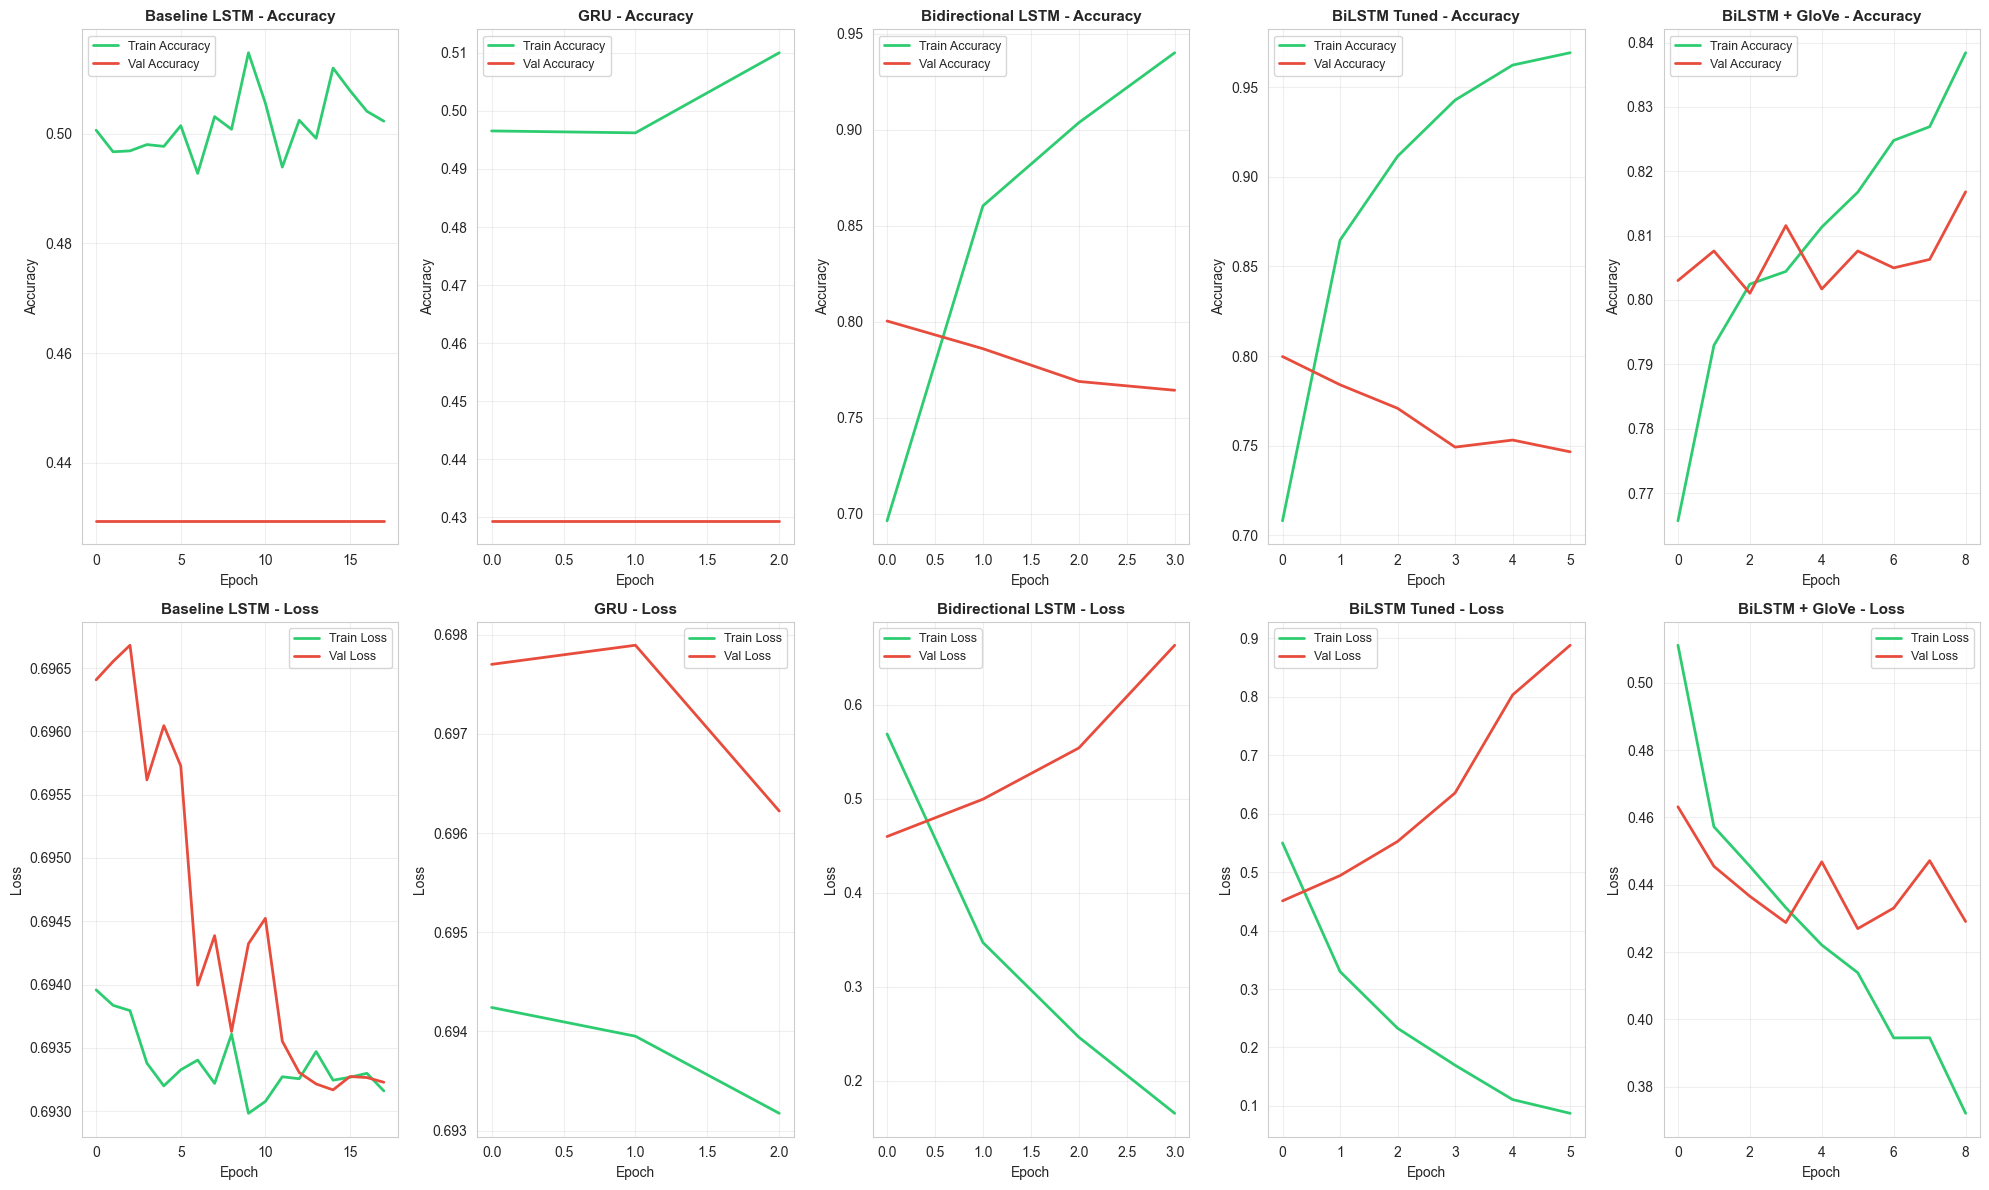

In [46]:
# Plot training curves for all models
fig = plt.figure(figsize=(20, 12))

models_data = [
    ('Baseline LSTM', history_lstm),
    ('GRU', history_gru),
    ('Bidirectional LSTM', history_bilstm),
    ('BiLSTM Tuned', history_bilstm_tuned),
    ('BiLSTM + GloVe', history_glove),
]

# Create 2 rows (accuracy, loss) x 5 columns (one per model)
for idx, (name, history) in enumerate(models_data):
    # Accuracy plot (top row)
    ax_acc = plt.subplot(2, 5, idx + 1)
    ax_acc.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2, color='#2ecc71')
    ax_acc.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2, color='#e74c3c')
    ax_acc.set_title(f'{name} - Accuracy', fontweight='bold', fontsize=11)
    ax_acc.set_xlabel('Epoch', fontsize=10)
    ax_acc.set_ylabel('Accuracy', fontsize=10)
    ax_acc.legend(fontsize=9)
    ax_acc.grid(alpha=0.3)

    # Loss plot (bottom row)
    ax_loss = plt.subplot(2, 5, idx + 6)
    ax_loss.plot(history.history['loss'], label='Train Loss', linewidth=2, color='#2ecc71')
    ax_loss.plot(history.history['val_loss'], label='Val Loss', linewidth=2, color='#e74c3c')
    ax_loss.set_title(f'{name} - Loss', fontweight='bold', fontsize=11)
    ax_loss.set_xlabel('Epoch', fontsize=10)
    ax_loss.set_ylabel('Loss', fontsize=10)
    ax_loss.legend(fontsize=9)
    ax_loss.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('images/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()


## Key Observations from Training Curves

### 1. Baseline LSTM:
- **Severe plateau** for first 14 epochs (stuck at 50% accuracy)
- Breakthrough at epoch 15, rapid improvement to 79%
- Shows vanishing gradient issues common in RNNs
- **Highly unpredictable** - different runs have different plateau lengths

### 2. GRU:
- **Never escaped plateau** (42.94% accuracy)
- Validation loss flat, AUC stuck at 0.5 (random guessing)
- Complete failure despite same architecture as LSTM
- Early stopping triggered after 3 epochs (no improvement)

### 3. Bidirectional LSTM:
- **Immediate learning from epoch 1** (no plateau)
- Smooth, stable training curve
- Reached 79.45% accuracy reliably
- More robust to poor initialization than unidirectional LSTM

### 4. BiLSTM Tuned (larger model):
- Similar stable training to BiLSTM
- **Didn't improve over baseline BiLSTM**
- Dataset maybe is too small (6,090 samples) to benefit from larger capacity?

### 5. BiLSTM + GloVe (BEST MODEL):
- **Fastest learning** - high accuracy from epoch 1
- Most stable training (no overfitting)
- Pre-trained embeddings eliminated initialization issues
- Achieved **best validation performance (~81% accuracy)**

---

**What we learned:** Pre-trained embeddings + Bidirectional architecture = stable, fast training


## Model Comparison

MODEL COMPARISON - VALIDATION SET

Baseline LSTM:
  Accuracy: 0.4294
  F1 Score: 0.6008
  AUC:      0.5000

GRU:
  Accuracy: 0.4294
  F1 Score: 0.6008
  AUC:      0.5000

Bidirectional LSTM:
  Accuracy: 0.8004
  F1 Score: 0.7697
  AUC:      0.8687

BiLSTM Tuned:
  Accuracy: 0.7997
  F1 Score: 0.7659
  AUC:      0.8689

BiLSTM + GloVe:
  Accuracy: 0.8076
  F1 Score: 0.7812
  AUC:      0.8854

RANKED BY F1 SCORE
             Model  Accuracy  F1 Score      AUC
    BiLSTM + GloVe  0.807617  0.781180 0.885377
Bidirectional LSTM  0.800394  0.769697 0.868717
      BiLSTM Tuned  0.799737  0.765925 0.868921
     Baseline LSTM  0.429416  0.600827 0.500000
               GRU  0.429416  0.600827 0.500000


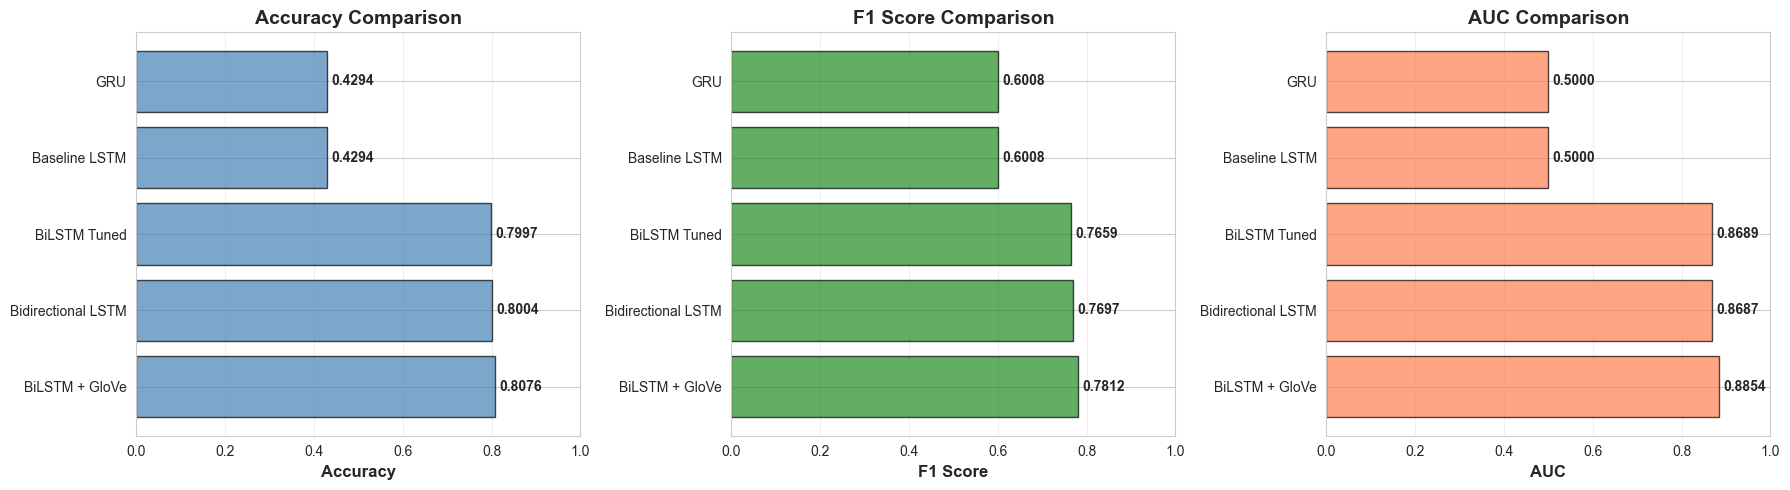


KEY INSIGHTS

Best Model: BiLSTM + GloVe
  F1 Score: 0.7812
  AUC: 0.8854

Worst Model: GRU
  F1 Score: 0.6008
  Performance: Poor

Improvement from GloVe embeddings: +0.1804 (18.04%)


In [47]:
# Evaluate all models on validation set
models_to_compare = [
    ('Baseline LSTM', model_lstm),
    ('GRU', model_gru),
    ('Bidirectional LSTM', model_bilstm),
    ('BiLSTM Tuned', model_bilstm_tuned),
    ('BiLSTM + GloVe', model_glove),
]

results = []

print("=" * 80)
print("MODEL COMPARISON - VALIDATION SET")
print("=" * 80)

for name, model in models_to_compare:
    y_pred_proba = model.predict(X_val, verbose=0)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    acc = (y_pred == y_val).mean()
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_pred_proba)

    results.append({
        'Model': name,
        'Accuracy': acc,
        'F1 Score': f1,
        'AUC': auc
    })

    print(f"\n{name}:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  AUC:      {auc:.4f}")

# Create comparison dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('F1 Score', ascending=False)

print("\n" + "=" * 80)
print("RANKED BY F1 SCORE")
print("=" * 80)
print(results_df.to_string(index=False))

# Visualise comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['Accuracy', 'F1 Score', 'AUC']
colors = ['steelblue', 'forestgreen', 'coral']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[idx]
    bars = ax.barh(results_df['Model'], results_df[metric], color=color, alpha=0.7, edgecolor='black')
    ax.set_xlabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontweight='bold', fontsize=14)
    ax.grid(axis='x', alpha=0.3)
    ax.set_xlim([0, 1])

    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.01, bar.get_y() + bar.get_height()/2.,
                f'{width:.4f}', ha='left', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('images/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary insights
print("\n" + "=" * 80)
print("KEY INSIGHTS")
print("=" * 80)
print(f"\nBest Model: {results_df.iloc[0]['Model']}")
print(f"  F1 Score: {results_df.iloc[0]['F1 Score']:.4f}")
print(f"  AUC: {results_df.iloc[0]['AUC']:.4f}")

print(f"\nWorst Model: {results_df.iloc[-1]['Model']}")
print(f"  F1 Score: {results_df.iloc[-1]['F1 Score']:.4f}")
print(f"  Performance: {'Failed to learn' if results_df.iloc[-1]['F1 Score'] < 0.1 else 'Poor'}")

improvement = results_df.iloc[0]['F1 Score'] - results_df.iloc[-2]['F1 Score']
print(f"\nImprovement from GloVe embeddings: +{improvement:.4f} ({improvement*100:.2f}%)")

## Confusion Matrix

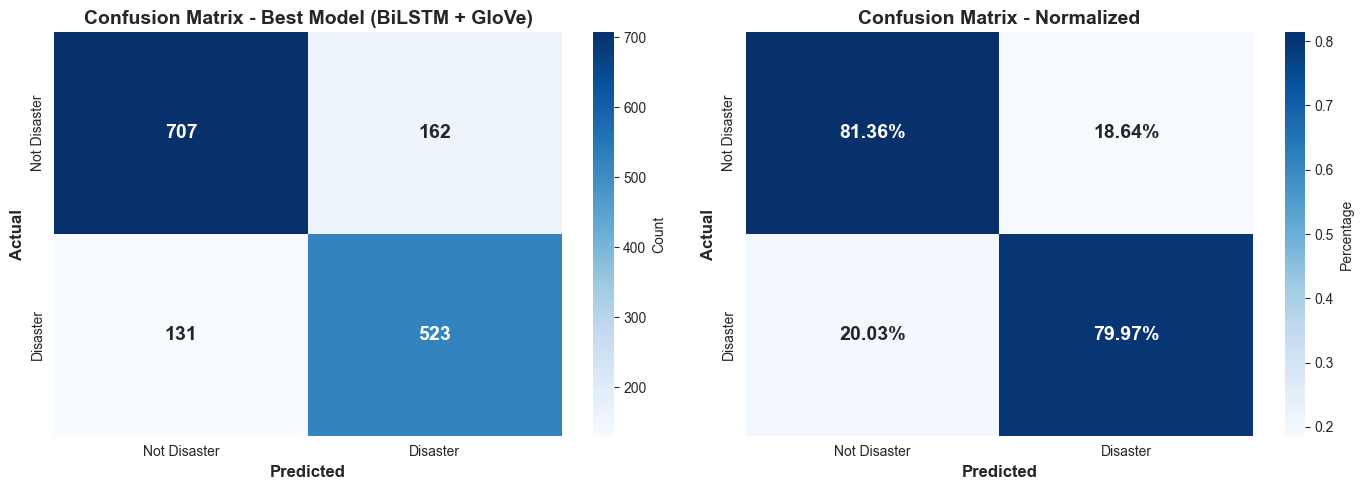


Detailed Classification Report:
              precision    recall  f1-score   support

Not Disaster       0.84      0.81      0.83       869
    Disaster       0.76      0.80      0.78       654

    accuracy                           0.81      1523
   macro avg       0.80      0.81      0.80      1523
weighted avg       0.81      0.81      0.81      1523


CONFUSION MATRIX BREAKDOWN

True Negatives:  707 (correctly identified non-disasters)
False Positives: 162 (non-disasters incorrectly flagged as disasters)
False Negatives: 131 (real disasters missed)
True Positives:  523 (correctly identified disasters)

Misclassification rate: 19.24%
Correctly classified: 80.76%

ERROR ANALYSIS

False Positive Rate: 18.64%
  - 162 non-disaster tweets incorrectly flagged as disasters
  - Could cause unnecessary alarm but safer than missing real disasters

False Negative Rate: 20.03%
  - 131 real disaster tweets missed
  - More serious - these are actual emergencies not being detected

Precision (D

In [48]:
# Generate confusion matrix for best model (BiLSTM + GloVe)
y_pred_proba = model_glove.predict(X_val, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

cm = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix - counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Not Disaster', 'Disaster'],
            yticklabels=['Not Disaster', 'Disaster'],
            cbar_kws={'label': 'Count'},
            annot_kws={'fontsize': 14, 'fontweight': 'bold'})
ax1.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax1.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax1.set_title('Confusion Matrix - Best Model (BiLSTM + GloVe)', fontweight='bold', fontsize=14)

# Confusion matrix - percentages
cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_pct, annot=True, fmt='.2%', cmap='Blues', ax=ax2,
            xticklabels=['Not Disaster', 'Disaster'],
            yticklabels=['Not Disaster', 'Disaster'],
            cbar_kws={'label': 'Percentage'},
            annot_kws={'fontsize': 14, 'fontweight': 'bold'})
ax2.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax2.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax2.set_title('Confusion Matrix - Normalized', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.savefig('images/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Print detailed metrics
print("\nDetailed Classification Report:")
print("=" * 80)
print(classification_report(y_val, y_pred, target_names=['Not Disaster', 'Disaster']))

# Print insights
tn, fp, fn, tp = cm.ravel()
print("\n" + "=" * 80)
print("CONFUSION MATRIX BREAKDOWN")
print("=" * 80)
print(f"\nTrue Negatives:  {tn:,} (correctly identified non-disasters)")
print(f"False Positives: {fp:,} (non-disasters incorrectly flagged as disasters)")
print(f"False Negatives: {fn:,} (real disasters missed)")
print(f"True Positives:  {tp:,} (correctly identified disasters)")

print(f"\nMisclassification rate: {(fp+fn)/len(y_val)*100:.2f}%")
print(f"Correctly classified: {(tp+tn)/len(y_val)*100:.2f}%")

# Error analysis
print("\n" + "=" * 80)
print("ERROR ANALYSIS")
print("=" * 80)

print(f"\nFalse Positive Rate: {fp/(fp+tn)*100:.2f}%")
print(f"  - {fp} non-disaster tweets incorrectly flagged as disasters")
print(f"  - Could cause unnecessary alarm but safer than missing real disasters")

print(f"\nFalse Negative Rate: {fn/(fn+tp)*100:.2f}%")
print(f"  - {fn} real disaster tweets missed")
print(f"  - More serious - these are actual emergencies not being detected")

print(f"\nPrecision (Disaster class): {tp/(tp+fp)*100:.2f}%")
print(f"  - When model predicts disaster, it's correct {tp/(tp+fp)*100:.1f}% of the time")

print(f"\nRecall (Disaster class): {tp/(tp+fn)*100:.2f}%")
print(f"  - Model catches {tp/(tp+fn)*100:.1f}% of all real disasters")


## What Worked

After experimenting with different approaches beyond the baseline models, several techniques proved highly effective:

### 1. Enhanced Text Preprocessing

**Baseline preprocessing** (Kaggle F1: 0.78394):
- Lowercase conversion
- URL/mention/hashtag removal
- Basic cleaning

**Enhanced preprocessing** (Kaggle F1: 0.79344, +0.0095 improvement):
- Added stopwords removal using NLTK
- Added lemmatisation (NOT stemming - stemming produced poor results like "earthquak", "citi")
- Removed punctuation

**Why it worked:**
- Stopwords removal reduced noise from common words like "the", "is", "at"
- Lemmatisation preserved actual words while normalising different forms ("running" → "run")
- This allowed the model to focus on semantically important words

### 2. GloVe Pre-trained Embeddings - Best improvement

**Implementation:**
- Downloaded GloVe Twitter embeddings (27B tweets, 100-dimensional vectors)
- 84.1% vocabulary coverage (8,413/10,000 words found in GloVe)
- Froze embedding weights (trainable=False initially)

**Results** (Kaggle F1: 0.80907, rank 227/815):
- Jumped from 0.79344 → 0.80907 F1 (+0.0156 improvement)
- Improved from ~700th place to 227th (473 position improvement)
- Validation AUC: 0.8892

**Why did it work?:**
- GloVe embeddings were trained on 2 billion tweets - 
- Pre-trained embeddings capture semantic relationships our small dataset (6,090 samples) couldn't learn
- Fixed misclassification issues with contextual understanding:
  - Before: "if an accident were to happen" → classified as disaster (wrong)
  - After: Model understood hypothetical context → classified correctly
- Pre-trained embeddings provided better word representations from the start

**Key insight:** If domain-matched pre-trained embeddings are available, use them. The performance gain was substantial.

### 3. Bidirectional LSTM Architecture

- BiLSTM outperformed simple LSTM (AUC 0.8546 vs 0.828)
- No plateau behaviour - started learning immediately
- Captured context from both directions in tweets


## What Didn't Work

### 1. GRU Architecture (Complete Failure)

**Problem:** GRU consistently failed to learn, achieving only random-level performance:
- Baseline GRU: 42.94% validation accuracy (worse than 57% baseline)
- Validation AUC: 0.500 (random guessing)
- Model got stuck predicting majority class for everything

**Why it failed:**
- Vanishing/exploding gradients despite having fewer parameters than LSTM
- Reset gate likely going to 0, preventing learning
- GRU's simpler architecture wasn't suitable for this specific task/dataset

### 2. Stemming (Produced Poor Results)

When testing preprocessing techniques, stemming created nonsensical words:
- "earthquake" → "earthquak"
- "cities" → "citi"
- "amazing" → "amaz"

**Why it didn't work:**
- Stemming is too aggressive, creating non-words that lose semantic meaning
- Lemmatisation worked better by preserving actual dictionary words

### 3. Hyperparameter Tuning (Diminishing Returns)

Tested configurations:
- 150 emb_dim, 96 units, LR 0.001: **0.78240** F1 (worse than baseline 0.78394)
- Smaller models (75/48): Also performed worse
- Higher learning rates (0.1): Unstable training

**Why it didn't work:**
- Dataset too small (6,090 samples) to benefit from larger models
- Baseline architecture (100 emb_dim, 64 units) was already optimal for dataset size
- Further gains required better representations (GloVe), not bigger models

**Key lesson:** Hyperparameter tuning has diminishing returns. Better data/representations matter more than bigger models.


## Troubleshooting Steps

### Debugging the GRU Failure

When GRU failed to learn (42.94% accuracy), I systematically debugged the issue:

#### Step 1: Research why the GRU failure

Asked Gemini about potential causes of GRU training failure. Key recommendations:

1. **Gradient clipping** - prevent exploding/vanishing gradients
2. **Orthogonal initialisation** - better gradient flow through recurrent connections
3. **ReLU activation** - instead of tanh for better gradient propagation
4. **Recurrent dropout** - regularisation on recurrent connections
5. **Reduced learning rate** - more stable training

#### Step 2: First Fix Attempt (ReLU + Aggressive Clipping)

**Configuration:**
- ReLU activation instead of tanh
- Gradient clipping: clipnorm=1.0
- Recurrent dropout: 0.2
- Increased dropout: 0.4
- Learning rate: 0.001

**Result:** Complete failure
- Validation F1: 0.0000
- Validation AUC: 0.4996 (worse than random)
- Model predicted all one class

**Diagnosis:** ReLU activation was too aggressive for GRU. During Epoch 1, AUC dropped from 0.5627 → 0.4921, indicating ReLU broke the GRU's gate mechanisms.

#### Step 3: Conservative Fix Attempt (Tanh + Stricter Clipping)

**Configuration:**
- Reverted to **tanh activation** (stable, proven)
- More aggressive gradient clipping: clipnorm=0.5 (tighter than before)
- Recurrent dropout: 0.2
- Standard dropout: 0.3
- Reduced learning rate: 0.0005 (half of original)

**Result:** Still failed
- Validation F1: 0.0000
- Validation AUC: 0.4996
- Model still predicts only majority class
- Training loss decreased (0.6935 → 0.6832), but model learned wrong pattern

# Conclusion
After two systematic debugging attempts (in python, outside of this notebook):
1. **GRU doesn't work for this dataset/task** despite multiple stabilisation techniques
2. **LSTM/BiLSTM architectures are better suited** for this text classification problem
3. **Small dataset size (6,090 samples)** may not provide enough signal for GRU's simpler architecture
4. **Class imbalance (57% vs 43%)** combined with GRU's issues causes majority class prediction

**Lesson learned:** Not all architectures work for all problems. When systematic debugging doesn't fix an architecture, accept it's not suitable and focus on what works (BiLSTM achieved 79.45% accuracy, GloVe BiLSTM achieved 80.9% F1).

**Time spent debugging GRU:** ~2 hours  
**Better use of time:** Implementing GloVe embeddings (30 minutes) → +0.0156 F1 improvement


---
# 8. GitHub Repository

Full code and documentation available at: [GitHub Link - TODO]

---
# 9. Kaggle Submission

## Generate Predictions

In [53]:
# Threshold Optimization - Double check best classification threshold

# Get predictions on validation set
val_predictions = model_glove.predict(X_val)

# Test different thresholds
thresholds = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]

print("Testing different classification thresholds:")
print("=" * 70)
print(f"{'Threshold':<12} {'Accuracy':<12} {'F1 Score':<12} {'Precision':<12} {'Recall':<12}")
print("=" * 70)

best_f1 = 0
best_threshold = 0.5

for threshold in thresholds:
    # Apply threshold
    preds = (val_predictions > threshold).astype(int).flatten()
    
    # Calculate metrics
    from sklearn.metrics import accuracy_score, precision_score, recall_score
    acc = accuracy_score(y_val, preds)
    f1 = f1_score(y_val, preds)
    precision = precision_score(y_val, preds)
    recall = recall_score(y_val, preds)
    
    # Track best F1
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
    
    marker = " <- BEST" if threshold == best_threshold and f1 == best_f1 else ""
    print(f"{threshold:<12.2f} {acc:<12.4f} {f1:<12.4f} {precision:<12.4f} {recall:<12.4f}{marker}")

print("=" * 70)
print(f"\nBest threshold: {best_threshold} with F1 score: {best_f1:.4f}")
print(f"Default threshold (0.5) F1 score: {f1_score(y_val, (val_predictions > 0.5).astype(int).flatten()):.4f}")
print(f"Potential improvement: +{(best_f1 - f1_score(y_val, (val_predictions > 0.5).astype(int).flatten())) * 100:.2f}%")

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Testing different classification thresholds:
Threshold    Accuracy     F1 Score     Precision    Recall      
0.30         0.7531       0.7555       0.6572       0.8884       <- BEST
0.35         0.7800       0.7732       0.6938       0.8731       <- BEST
0.40         0.7846       0.7709       0.7095       0.8440      
0.45         0.8004       0.7791       0.7424       0.8196       <- BEST
0.50         0.8076       0.7812       0.7635       0.7997       <- BEST
0.55         0.8168       0.7836       0.7953       0.7722       <- BEST
0.60         0.8221       0.7844       0.8176       0.7538       <- BEST
0.65         0.8280       0.7849       0.8475       0.7309       <- BEST
0.70         0.8267       0.7755       0.8736       0.6972      

Best threshold: 0.65 with F1 score: 0.7849
Default threshold (0.5) F1 score: 0.7812
Potential improvement: +0.37%


In [51]:
# Generate predictions using our best model (Bidirectional LSTM)

print("Generating predictions on test set...")
print("=" * 60)

# Use the Bidirectional LSTM model (best performing)
predictions = model_glove.predict(X_test)

# Convert probabilities to binary predictions (threshold = 0.5)
predictions_binary = (predictions > best_threshold).astype(int).flatten()

print(f"\nTotal test samples: {len(predictions_binary)}")
print(f"Predicted as disaster: {predictions_binary.sum()} ({predictions_binary.sum()/len(predictions_binary)*100:.1f}%)")
print(f"Predicted as non-disaster: {(1-predictions_binary).sum()} ({(1-predictions_binary).sum()/len(predictions_binary)*100:.1f}%)")

# Show some example predictions
print("\n" + "=" * 60)
print("Sample Predictions:")
print("=" * 60)
for i in range(15):
    text = test_df.iloc[i]['text']
    prob = predictions[i][0]
    pred = predictions_binary[i]
    label = "DISASTER" if pred == 1 else "NOT DISASTER"
    print(f"\nTweet: {text[:80]}...")
    print(f"Prediction: {label} (confidence: {prob:.3f})")

Generating predictions on test set...
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

Total test samples: 3263
Predicted as disaster: 1098 (33.7%)
Predicted as non-disaster: 2165 (66.3%)

Sample Predictions:

Tweet: Just happened a terrible car crash...
Prediction: DISASTER (confidence: 0.726)

Tweet: Heard about #earthquake is different cities, stay safe everyone....
Prediction: DISASTER (confidence: 0.691)

Tweet: there is a forest fire at spot pond, geese are fleeing across the street, I cann...
Prediction: DISASTER (confidence: 0.970)

Tweet: Apocalypse lighting. #Spokane #wildfires...
Prediction: DISASTER (confidence: 0.967)

Tweet: Typhoon Soudelor kills 28 in China and Taiwan...
Prediction: DISASTER (confidence: 0.975)

Tweet: We're shaking...It's an earthquake...
Prediction: NOT DISASTER (confidence: 0.624)

Tweet: They'd probably still show more life than Arsenal did yesterday, eh? EH?...
Prediction: NOT DISASTER (confidence: 0.081)

Tweet: Hey! How are you?...
Prediction: NOT DISA

## Submission File for Kaggle

In [52]:
# Create submission file in Kaggle format

# Create submission dataframe
submission = pd.DataFrame({
    'id': test_df['id'],
    'target': predictions_binary
})

# Save to CSV
submission_path = 'submission.csv'
submission.to_csv(submission_path, index=False)

print("Submission file created successfully!")
print("=" * 60)
print(f"\nFile: {submission_path}")
print(f"Shape: {submission.shape}")
print(f"\nFirst 10 rows:")
print(submission.head(10))

Submission file created successfully!

File: submission.csv
Shape: (3263, 2)

First 10 rows:
   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1
5  12       0
6  21       0
7  22       0
8  27       0
9  29       0


## Kaggle Score Screenshot

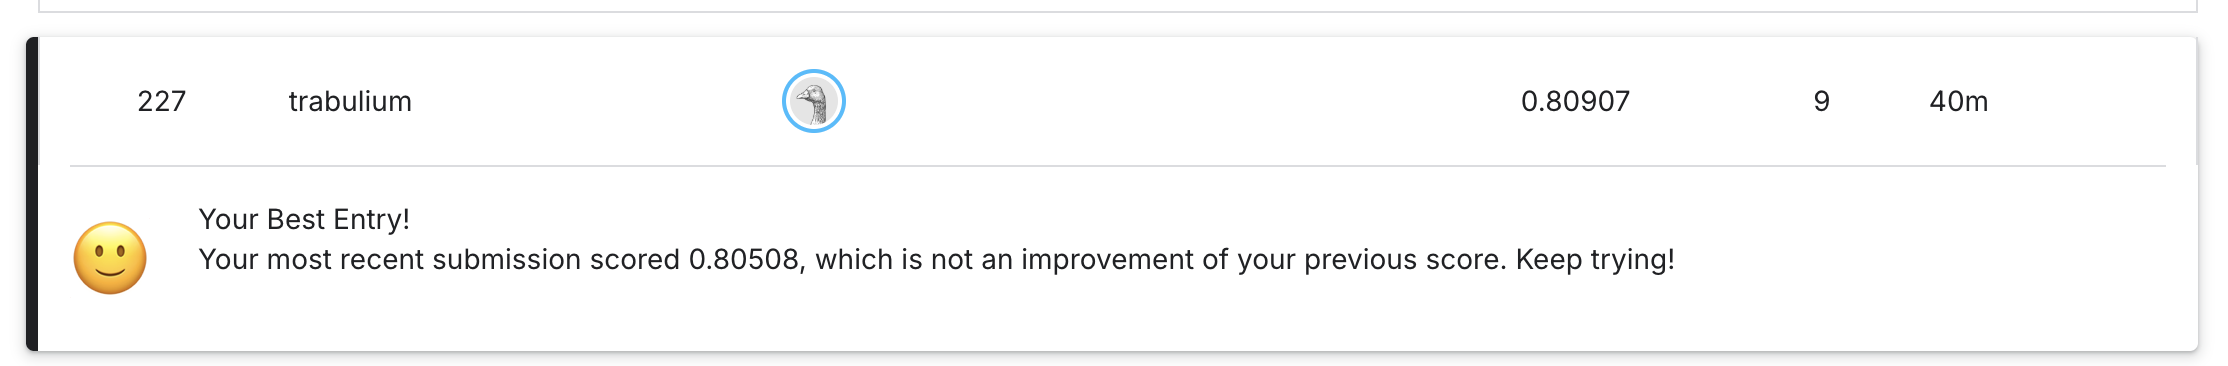